In [97]:
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torch
from pathlib import Path
import numpy as np
from utils.models2 import Classifier
import torch.nn as nn
from utils.loader import Loader
import logging
import argparse
from torch.utils.tensorboard import SummaryWriter

In [98]:
# Dataset definition
class RawDataset(Dataset):
    def __init__(self, datasetPath, sampleFile, modals=0):
        self.path = datasetPath 
        self.samples = np.loadtxt(sampleFile, dtype=str)
        

    def __getitem__(self, index):
        inputIndex  = self.samples[index, 0]
        classLabel  = int(self.samples[index, 1])
        #desiredClass = torch.zeros((20, 1, 1, 1))
        #desiredClass[classLabel,...] = 1
        inputSpikes_tact_left = torch.FloatTensor( np.load(self.path + inputIndex + '_left.npy') )
        inputSpikes_tact_right = torch.FloatTensor( np.load(self.path + inputIndex+ '_right.npy') )    
        return inputSpikes_tact_left, inputSpikes_tact_right, classLabel
        
    def __len__(self):
        return self.samples.shape[0]


device = torch.device('cuda:0')




class FLAGS():
    def __init__(self):
        self.batch_size = 100
        self.pin_memory =True
        self.num_workers = 1
        self.device = device
flags = FLAGS()
criterion = torch.nn.CrossEntropyLoss()



In [126]:
data_dir ='../../diag_data/july30/'
sample_file = 1
output_size = 6
model_path = '/home/tasbolat/tas_python_env/.guild/runs/9feafbcc83944983b9536060aeb9e5b3/weights-300.pt'

In [127]:
    
trainingSet = RawDataset(datasetPath = data_dir + 'tact_rpg_data/', 
                        sampleFile = data_dir + "/train_80_20_" + str(sample_file) + ".txt")
train_loader = Loader(trainingSet, flags, device=device)    
testingSet = RawDataset(datasetPath = data_dir + 'tact_rpg_data/', 
                        sampleFile  = data_dir + "/test_80_20_"  + str(sample_file) + ".txt")
test_loader = Loader(testingSet, flags, device=device)

# model parameters

voxel_dimension=(5,7,9)
mlp_layers=[1, 30, 30, 1]
activation=nn.LeakyReLU(negative_slope=0.1)


model = Classifier(voxel_dimension=voxel_dimension, 
                     mlp_layers=mlp_layers, 
                     activation=activation, num_classes=output_size).to(device)

In [128]:
model.load_state_dict(torch.load(model_path))
model.eval()

Classifier(
  (quantization_layer1): QuantizationLayer(
    (value_layer): ValueLayer(
      (mlp): ModuleList(
        (0): Linear(in_features=1, out_features=30, bias=True)
        (1): Linear(in_features=30, out_features=30, bias=True)
        (2): Linear(in_features=30, out_features=1, bias=True)
      )
      (activation): LeakyReLU(negative_slope=0.1)
    )
  )
  (quantization_layer2): QuantizationLayer(
    (value_layer): ValueLayer(
      (mlp): ModuleList(
        (0): Linear(in_features=1, out_features=30, bias=True)
        (1): Linear(in_features=30, out_features=30, bias=True)
        (2): Linear(in_features=30, out_features=1, bias=True)
      )
      (activation): LeakyReLU(negative_slope=0.1)
    )
  )
  (classifier): SimpleNet(
    (conv1): Conv2d(20, 30, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (relu1): ReLU()
    (conv2): Conv2d(30, 80, kernel_size=(3, 3), stride=(1, 1))
    (relu2): ReLU()
    (fc): Linear(in_features=1200, out_features=6, bias=True)
  )
)

In [129]:
correct = 0
sum_loss = 0
model.eval()
with torch.no_grad():
    for events1, events2, labels in test_loader:       
        out, vox1, vox2 = model.forward(events1, events2)
        loss = criterion(out, labels)
        _, predicted = torch.max(out.data, 1)
        correct += (predicted == labels).sum().item()        
validation_loss = sum_loss / len(testingSet)
validation_accuracy = correct / len(testingSet)

In [130]:
correct/30

0.7

In [131]:
labels.cpu().numpy()

array([2, 0, 0, 1, 2, 4, 5, 3, 1, 3, 5, 5, 4, 5, 2, 4, 2, 3, 1, 2, 3, 0,
       1, 0, 1, 0, 4, 4, 5, 3])

In [132]:
len(testingSet)

30

In [133]:
count = 0
total_testing_true=None
testing_true = torch.zeros([len(testingSet),2])
ll = []
for events1, events2, labels in test_loader:
    label = labels.cpu()
    testing_true[count:count+label.shape[0],0] = label
    with torch.no_grad():
        # Forward pass of the network.
        out, vox1, vox2 = model.forward(events1, events2)
        _, predicted_label = torch.max(out.data, 1)
        testing_true[count:count+label.shape[0],1] = predicted_label
    count += label.shape[0]
    ll.append(label)
if total_testing_true is None:
    total_testing_true = testing_true
else:
    total_testing_true = torch.cat([total_testing_true, testing_true])

In [134]:
from sklearn.metrics import confusion_matrix

In [135]:
cm = confusion_matrix(testing_true[:,0].numpy(), testing_true[:,1].numpy()).T

In [136]:
import seaborn as sn

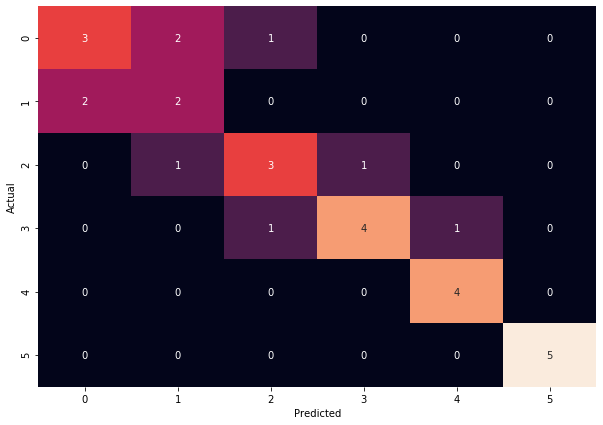

In [137]:
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, cbar=False)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig('imgs_july30/rpg_both_samplefile_' + str(sample_file) + '.png')
plt.show()